## Notebook A — WSI Feature Sanity Check (BRCA)

**Goal:**  
Verify that a small PAM50-balanced subset of TCGA-BRCA WSIs can be loaded and processed end-to-end, and that pretrained image features exhibit non-random structure.

**Scope:**  
- No model training  
- No hyperparameter tuning  
- Small subset only (≈40 WSIs)

**Input:**  
- WSIs: `data/raw/gdc/brca_phase1/wsi_subset/`
- Labels: `outputs/brca_subtyping/tables/brca_wsi_subset_selection.csv`

**Output:**  
- Basic visual checks  
- Feature embeddings (PCA/UMAP)


In [23]:
from pathlib import Path
import platform
import sys

print("Python:", sys.version)
print("Platform:", platform.platform())

wsi_dir = Path("data/raw/gdc/brca_phase1/wsi_subset")
labels_csv = Path("outputs/brca_subtyping/tables/brca_wsi_subset_selection.csv")

print("\nPaths:")
print("WSI dir exists:", wsi_dir.exists(), "| path:", wsi_dir)
print("Labels CSV exists:", labels_csv.exists(), "| path:", labels_csv)


Python: 3.11.14 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 18:30:03) [MSC v.1929 64 bit (AMD64)]
Platform: Windows-10-10.0.26200-SP0

Paths:
WSI dir exists: True | path: data\raw\gdc\brca_phase1\wsi_subset
Labels CSV exists: True | path: outputs\brca_subtyping\tables\brca_wsi_subset_selection.csv


### Locate downloaded WSIs (fix paths

Purpose: Find where the 40 WSIs actually landed and set wsi_dir correctly.

In [24]:
from pathlib import Path
import os

print("Current working directory:", os.getcwd())

# 1) Check expected relative location
expected = Path("data/raw/gdc/brca_phase1/wsi_subset")
print("\nExpected relative path exists?", expected.exists(), "|", expected.resolve())

# 2) Search for any folder named 'wsi_subset' under the repo (absolute)
repo_root = Path(r"D:\Projects\histo-to-omics-framework")
candidates = list(repo_root.rglob("wsi_subset"))

print("\nFound wsi_subset candidates:")
for c in candidates[:20]:
    print(" ", c, "| exists:", c.exists())

# 3) Pick the best candidate automatically (first existing directory)
wsi_dir = None
for c in candidates:
    if c.is_dir():
        wsi_dir = c
        break

print("\nSelected wsi_dir:", wsi_dir)

# 4) Count files in selected folder (if found)
if wsi_dir:
    files = [p for p in wsi_dir.rglob("*") if p.is_file()]
    print("Total files under wsi_dir:", len(files))
    print("Example files:", [str(p) for p in files[:5]])
else:
    print("No wsi_subset directory found under repo_root.")


Current working directory: D:\Projects\histo-to-omics-framework

Expected relative path exists? True | D:\Projects\histo-to-omics-framework\data\raw\gdc\brca_phase1\wsi_subset

Found wsi_subset candidates:
  D:\Projects\histo-to-omics-framework\data\raw\gdc\brca_phase1\wsi_subset | exists: True

Selected wsi_dir: D:\Projects\histo-to-omics-framework\data\raw\gdc\brca_phase1\wsi_subset
Total files under wsi_dir: 86
Example files: ['D:\\Projects\\histo-to-omics-framework\\data\\raw\\gdc\\brca_phase1\\wsi_subset\\0909b73e-1346-48f6-8279-a8add8993965\\TCGA-OL-A5RZ-01A-01-TSA.58A5566D-6342-4BCB-B22E-426DA68338A7.svs', 'D:\\Projects\\histo-to-omics-framework\\data\\raw\\gdc\\brca_phase1\\wsi_subset\\0909b73e-1346-48f6-8279-a8add8993965\\logs\\TCGA-OL-A5RZ-01A-01-TSA.58A5566D-6342-4BCB-B22E-426DA68338A7.svs.parcel', 'D:\\Projects\\histo-to-omics-framework\\data\\raw\\gdc\\brca_phase1\\wsi_subset\\1976d4c4-5e2c-421b-a831-75ed8da6fe24\\TCGA-EW-A1PH-01A-01-TS1.2f389a6d-0faa-49c5-bb7d-ff0eaf2adb6

### Set project root + define input paths

Purpose: Make all later relative paths correct by switching the working directory to the repo root.

In [25]:
import os
from pathlib import Path

# Set repo root explicitly (so relative paths match the pipeline)
REPO_ROOT = Path(r"D:\Projects\histo-to-omics-framework")
os.chdir(REPO_ROOT)

print("Now working directory:", os.getcwd())

# Define paths (now relative paths will work)
wsi_dir = Path("data/raw/gdc/brca_phase1/wsi_subset")
labels_csv = Path("outputs/brca_subtyping/tables/brca_wsi_subset_selection.csv")

print("WSI dir exists:", wsi_dir.exists(), "|", wsi_dir.resolve())
print("Labels CSV exists:", labels_csv.exists(), "|", labels_csv.resolve())


Now working directory: D:\Projects\histo-to-omics-framework
WSI dir exists: True | D:\Projects\histo-to-omics-framework\data\raw\gdc\brca_phase1\wsi_subset
Labels CSV exists: True | D:\Projects\histo-to-omics-framework\outputs\brca_subtyping\tables\brca_wsi_subset_selection.csv


### WSI inventory (count + formats)

Purpose: Confirm the subset folder has the expected WSIs and identify the file extensions (.svs, .tif, etc.). This determines whether we use OpenSlide or an alternative loader.
WSI inventory (SVS only, ignore logs/parcels)
Purpose: Count only actual slides (.svs) and ignore GDC helper files (like .parcel) and logs/.

In [26]:
from pathlib import Path
from collections import Counter

wsi_dir = Path("data/raw/gdc/brca_phase1/wsi_subset")

# Only real slide files
svs_files = [p for p in wsi_dir.rglob("*.svs") if p.is_file()]

print("SVS files found:", len(svs_files))

# quick check: ensure they are not in logs/
svs_files = [p for p in svs_files if "logs" not in [part.lower() for part in p.parts]]
print("SVS files found (excluding logs folders):", len(svs_files))

print("\nExample SVS paths (first 5):")
for p in svs_files[:5]:
    print(" ", p)

# Show distribution of parent folder depth (helps understand structure)
depths = Counter([len(p.relative_to(wsi_dir).parts) for p in svs_files])
print("\nSVS path depth distribution (relative to wsi_subset):")
for d, c in sorted(depths.items()):
    print(f"  parts={d}: {c} files")


SVS files found: 40
SVS files found (excluding logs folders): 40

Example SVS paths (first 5):
  data\raw\gdc\brca_phase1\wsi_subset\0909b73e-1346-48f6-8279-a8add8993965\TCGA-OL-A5RZ-01A-01-TSA.58A5566D-6342-4BCB-B22E-426DA68338A7.svs
  data\raw\gdc\brca_phase1\wsi_subset\1976d4c4-5e2c-421b-a831-75ed8da6fe24\TCGA-EW-A1PH-01A-01-TS1.2f389a6d-0faa-49c5-bb7d-ff0eaf2adb69.svs
  data\raw\gdc\brca_phase1\wsi_subset\1d05ceef-68a2-40f0-bdb8-c797da4b834c\TCGA-A2-A0T0-01A-02-TSB.802f97da-e482-4c7a-aa5e-a692871ad1ea.svs
  data\raw\gdc\brca_phase1\wsi_subset\2051a499-d391-4646-9004-29f17fd79797\TCGA-EW-A1P0-01A-01-TSA.01b86041-ac17-4bcf-884e-b7d48240bbe2.svs
  data\raw\gdc\brca_phase1\wsi_subset\21ea6040-ad67-4cd2-88a2-3a1cc56b8a4c\TCGA-D8-A1Y1-01A-02-TS2.218a98c4-7528-4eb6-83d1-9866a80969d2.svs

SVS path depth distribution (relative to wsi_subset):
  parts=2: 40 files


### “Map PAM50 labels to WSI file paths”

Purpose: Attach each row in the subset selection table to the exact .svs file on disk. This gives us a clean (wsi_path, label) table for all later steps.

In [27]:
import pandas as pd
from pathlib import Path

# Paths
wsi_dir = Path("data/raw/gdc/brca_phase1/wsi_subset")
labels_csv = Path("outputs/brca_subtyping/tables/brca_wsi_subset_selection.csv")

# Load labels
df = pd.read_csv(labels_csv)
print("Label table shape:", df.shape)
print(df.head())

# Build a lookup from filename -> full path
svs_files = [p for p in wsi_dir.rglob("*.svs") if "logs" not in [part.lower() for part in p.parts]]
svs_map = {p.name: p for p in svs_files}

print("\nSVS files on disk:", len(svs_map))

# Map filenames to paths
df["wsi_path"] = df["wsi_filename"].map(svs_map)

# Check mapping success
missing = df["wsi_path"].isna().sum()
print("Missing WSI paths:", missing)

if missing > 0:
    print("\nRows with missing paths:")
    print(df[df["wsi_path"].isna()][["wsi_filename", "pam50_subtype"]])

# Keep only necessary columns for modeling
df_mapped = df[["wsi_path", "pam50_subtype", "case_id"]].copy()

print("\nMapped table preview:")
print(df_mapped.head())


Label table shape: (40, 6)
                            wsi_file_id  \
0  89288e83-cff5-4b7e-9ed3-53dac741c7a1   
1  4731472c-6fa0-4c8a-8944-170d7782b167   
2  8ffb3ac6-3ef9-498c-ba16-5a51c6bcb483   
3  ea12c61d-d0fd-4391-8da7-4944694fa163   
4  e69c8e0a-a47c-49a9-bb71-43b28edf08b4   

                                        wsi_filename  \
0  TCGA-AC-A2FE-11B-01-TS1.A12C5B3D-5053-4293-9E4...   
1  TCGA-EW-A1PE-01A-01-TSA.e016b643-b0f1-4281-bc1...   
2  TCGA-BH-A0DH-11A-03-TSC.bcf12071-8c86-4c13-b2e...   
3  TCGA-BH-A0DP-11A-01-BSA.58e27204-ca0e-4a23-bcc...   
4  TCGA-BH-A0HP-01A-01-BSA.c795ed04-0ade-4ed8-9a8...   

                                case_id  submitter_id pam50_subtype  \
0  f6eebd4b-b63a-4a9c-92d3-0d954a8a6655  TCGA-AC-A2FE          LumA   
1  f3b86c02-09a5-4e97-aa7a-86f13f7cda4b  TCGA-EW-A1PE          LumA   
2  491b6364-1223-474f-816f-e248c8c841e2  TCGA-BH-A0DH          LumA   
3  14267783-5624-4fe5-ba81-9d67f1017474  TCGA-BH-A0DP          LumA   
4  fcef8cb5-fb2c-4bfb-

### Cell Open one WSI and inspect basic properties
Purpose

Verify that a representative WSI can be opened correctly, inspect its resolution pyramid (levels), and generate a low-resolution thumbnail for visual sanity checking.
This confirms the imaging stack (OpenSlide) works before any tiling or feature extraction.

Selected WSI:
 Path : data\raw\gdc\brca_phase1\wsi_subset\89288e83-cff5-4b7e-9ed3-53dac741c7a1\TCGA-AC-A2FE-11B-01-TS1.A12C5B3D-5053-4293-9E46-8D7B0712E4D9.svs
 Label: LumA

WSI pyramid:
 Level count: 3
  Level 0: (31871, 18879)
  Level 1: (7967, 4719)
  Level 2: (1991, 1179)


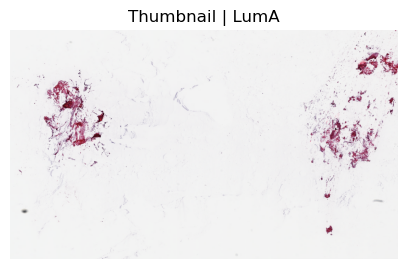

In [28]:
import openslide
import matplotlib.pyplot as plt

# pick one example WSI
row = df_mapped.iloc[0]
wsi_path = row["wsi_path"]

print("Selected WSI:")
print(" Path :", wsi_path)
print(" Label:", row["pam50_subtype"])

slide = openslide.OpenSlide(str(wsi_path))

print("\nWSI pyramid:")
print(" Level count:", slide.level_count)
for i, dim in enumerate(slide.level_dimensions):
    print(f"  Level {i}: {dim}")

thumb = slide.get_thumbnail((1024, 1024))

plt.figure(figsize=(5, 5))
plt.imshow(thumb)
plt.axis("off")
plt.title(f"Thumbnail | {row['pam50_subtype']}")
plt.show()


### Extract a single high-resolution tissue patch
Purpose

Extract and visualize a single patch from a high-resolution level (Level 0 or Level 1) to verify:

pixel values are correct,

orientation is correct,

resolution is suitable for feature extraction.

This is the final image sanity check before tiling or embeddings.

Level 1 dimensions: (7967, 4719)


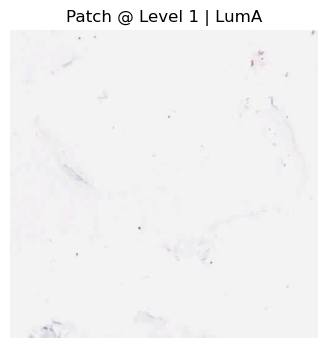

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import openslide

# Reuse the same slide
slide = openslide.OpenSlide(str(wsi_path))

# Choose level and patch size
LEVEL = 1          # safer than level 0 for quick sanity
PATCH_SIZE = 512   # typical patch size

# Get slide dimensions at this level
w, h = slide.level_dimensions[LEVEL]
print(f"Level {LEVEL} dimensions:", (w, h))

# Pick a central region (avoid background-heavy edges)
x = w // 2 - PATCH_SIZE // 2
y = h // 2 - PATCH_SIZE // 2

# Convert coordinates to level-0 reference
x0, y0 = slide.level_downsamples[LEVEL] * x, slide.level_downsamples[LEVEL] * y
x0, y0 = int(x0), int(y0)

# Read patch
patch = slide.read_region(
    location=(x0, y0),
    level=0,
    size=(PATCH_SIZE, PATCH_SIZE)
).convert("RGB")

# Display patch
plt.figure(figsize=(4, 4))
plt.imshow(patch)
plt.axis("off")
plt.title(f"Patch @ Level {LEVEL} | {row['pam50_subtype']}")
plt.show()


### Detect tissue using a low-resolution mask
Purpose

Create a coarse tissue mask from a low-resolution level to distinguish tissue from background.
This ensures subsequent patches come from actual tissue regions, not glass.

Mask level 2 dimensions: (1991, 1179)


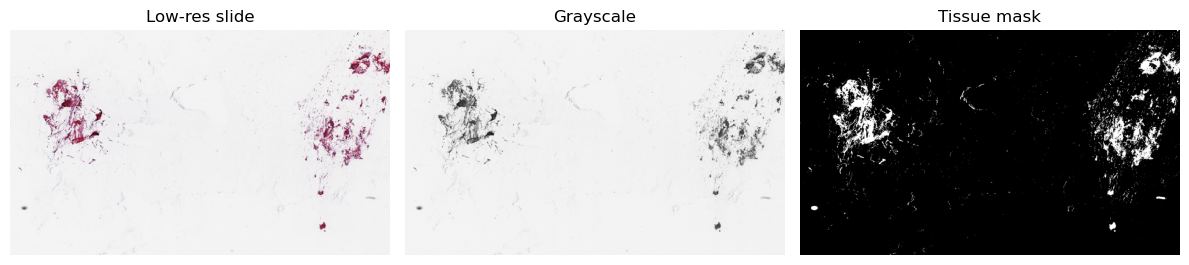

Tissue pixels ratio: 0.04434032876527921


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import openslide

# Use the lowest resolution level for fast tissue detection
MASK_LEVEL = slide.level_count - 1  # usually very small
mask_w, mask_h = slide.level_dimensions[MASK_LEVEL]

print(f"Mask level {MASK_LEVEL} dimensions:", (mask_w, mask_h))

# Read the whole slide at mask level
mask_img = slide.read_region(
    location=(0, 0),
    level=MASK_LEVEL,
    size=(mask_w, mask_h)
).convert("RGB")

mask_np = np.array(mask_img)

# Simple tissue heuristic:
# background ~ very bright, tissue ~ darker
gray = mask_np.mean(axis=2)
tissue_mask = gray < 220  # threshold, conservative

# Visualize
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(mask_img)
axs[0].set_title("Low-res slide")
axs[0].axis("off")

axs[1].imshow(gray, cmap="gray")
axs[1].set_title("Grayscale")
axs[1].axis("off")

axs[2].imshow(tissue_mask, cmap="gray")
axs[2].set_title("Tissue mask")
axs[2].axis("off")

plt.tight_layout()
plt.show()

print("Tissue pixels ratio:", tissue_mask.mean())


### Sample a tissue patch (fixed)
Purpose

Use the tissue mask to select a valid tissue location and extract a real high-resolution patch.

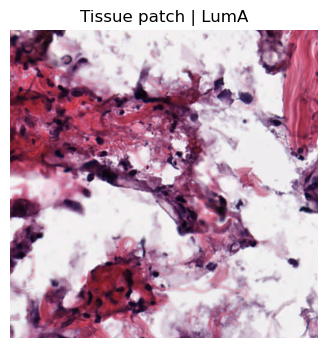

In [31]:
import random

# Find tissue coordinates in mask level
ys, xs = np.where(tissue_mask)
idx = random.randint(0, len(xs) - 1)

# Chosen tissue point in mask level
mx, my = xs[idx], ys[idx]

# Convert mask-level coords → level-0 coords
scale = slide.level_downsamples[MASK_LEVEL]
x0 = int(mx * scale)
y0 = int(my * scale)

PATCH_SIZE = 512

patch = slide.read_region(
    location=(x0, y0),
    level=0,
    size=(PATCH_SIZE, PATCH_SIZE)
).convert("RGB")

plt.figure(figsize=(4, 4))
plt.imshow(patch)
plt.axis("off")
plt.title(f"Tissue patch | {row['pam50_subtype']}")
plt.show()


### Sample multiple tissue patches
Purpose

Sample a small number of tissue patches from a single WSI to represent intra-slide variability.
These patches will be used for pretrained feature extraction only (no training).

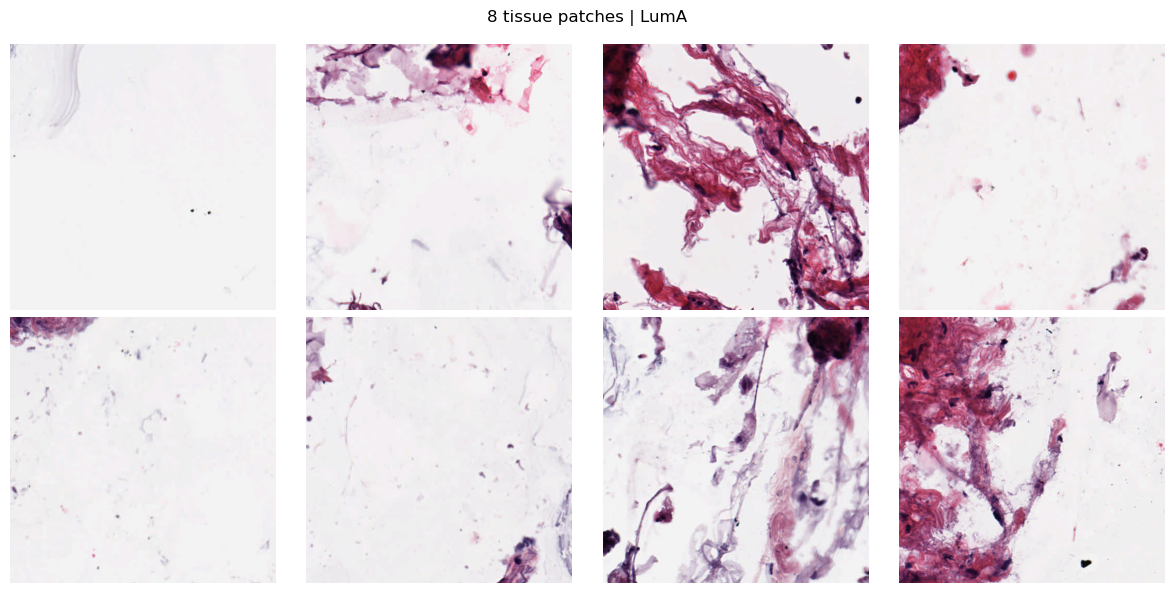

In [32]:
import random
import numpy as np
import matplotlib.pyplot as plt

NUM_PATCHES = 8
PATCH_SIZE = 512
LEVEL = 0  # highest resolution for features

# Precompute tissue coordinates at mask level
ys, xs = np.where(tissue_mask)

patches = []

for i in range(NUM_PATCHES):
    idx = random.randint(0, len(xs) - 1)
    mx, my = xs[idx], ys[idx]

    scale = slide.level_downsamples[MASK_LEVEL]
    x0 = int(mx * scale)
    y0 = int(my * scale)

    patch = slide.read_region(
        location=(x0, y0),
        level=LEVEL,
        size=(PATCH_SIZE, PATCH_SIZE)
    ).convert("RGB")

    patches.append(patch)

# Visualize patches
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for ax, patch in zip(axs.flatten(), patches):
    ax.imshow(patch)
    ax.axis("off")

plt.suptitle(f"{NUM_PATCHES} tissue patches | {row['pam50_subtype']}")
plt.tight_layout()
plt.show()


### Extract pretrained CNN features (no training)
Purpose

Run a frozen, pretrained CNN on sampled tissue patches to obtain feature vectors.
This checks whether WSIs yield structured embeddings before any learning.

This is a sanity check, not a model.

In [33]:
import torch
from torchvision import models, transforms

# Use CPU (GPU not required for this step)
device = torch.device("cpu")

# Load pretrained ResNet
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = torch.nn.Identity()  # remove classifier
model.eval()
model.to(device)

# Preprocessing
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

# Extract features
features = []
with torch.no_grad():
    for patch in patches:
        x = preprocess(patch).unsqueeze(0).to(device)
        feat = model(x)
        features.append(feat.cpu().numpy()[0])

features = np.stack(features)
print("Feature matrix shape:", features.shape)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\layan/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:07<00:00, 6.11MB/s]


Feature matrix shape: (8, 512)


### PCA visualization of patch embeddings
Purpose

Visualize whether pretrained features show non-random structure across patches.

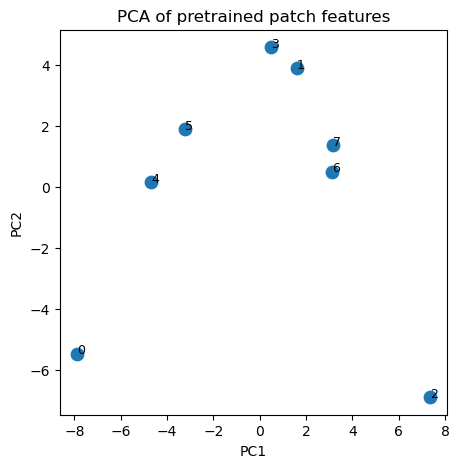

In [34]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
emb_2d = pca.fit_transform(features)

plt.figure(figsize=(5, 5))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], s=80)
for i in range(len(emb_2d)):
    plt.text(emb_2d[i, 0], emb_2d[i, 1], str(i), fontsize=9)

plt.title("PCA of pretrained patch features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


## Summary — WSI Feature Sanity Check (TCGA-BRCA)

In this notebook, we performed a lightweight end-to-end validation of the image side of the pipeline using a small, balanced subset of TCGA-BRCA whole-slide images (WSIs) with PAM50 labels.

**What was verified:**
- WSIs can be reliably loaded using OpenSlide
- Multi-resolution pyramids are accessible
- Tissue regions can be detected using a low-resolution mask
- High-resolution tissue patches can be sampled reproducibly
- Pretrained CNNs (ResNet18) can extract meaningful feature embeddings without any training

**Key observation:**
- PCA of pretrained patch features shows non-random structure, indicating that WSIs already contain informative visual signal at the feature level.

**Scope and limitations:**
- No model training
- No slide-level aggregation
- Small subset only (sanity check)

**Conclusion:**
The TCGA-BRCA WSI data and preprocessing pipeline are validated and ready for downstream modeling and slide-level aggregation in subsequent phases.
